# Recommending songs from the GTZAN dataset

*The GTZAN Dataset (http://marsyas.info/downloads/datasets.html) was collected between 2000 and 2001, and used for the paper in genre classification " Musical genre classification of audio signals " by G. Tzanetakis and P. Cook in IEEE Transactions on Audio and Speech Processing 2002. Since then, it has been a popular choice for subsequent work on musical genre classification using machine learning.*

### Project Aim

The goal of this recommender system is to find similar songs that a user might enjoy, based on the similarity of their aural content, and uninfluenced by arbitrary and subjective labels and metrics. Thus, this similarity will be measured using features directly extracted from the available audio files in the dataset.

1. The audio files that comprise the dataset are used to extract characteristic audio features. The values of such features are used to populate a dataframe.

2. A K-Nearest Neighbors classifier is instantiated and fit to the GTZAN features, using the Mahalanobis distance as a metric for their similarity.

3. A simple internal song recommender is created, functioning by picking a song that exists in the database and finding the entries with highest similarity score.

4. The final goal is a system that receives an audio file as input, extracts its features, and recalculates the similarity between the songs in the existing dataset as well as the new entry, in order to give recommendations.

#### Acknowledgements

* Credit should go to Andrada Olteanu who uploaded the dataset in this form on Kaggle(https://www.kaggle.com/andradaolteanu/gtzan-dataset-music-genre-classification), and has provided well documented examples features extraction, classification tasks, and a basis for a recommender system upon which this work expands.

* Credit must also be given to B.L. Sturm, for the invaluable contribution of providing a dataframe with the majority of the artists and song titles included in the GTZAN dataset.
  
  [B. L. Sturm, "An Analysis of the GTZAN Music Genre Dataset",
Proc. ACM Workshop MIRUM, Nara, Japan, Nov. 2012]




*In order to access the sound files comprising the GTZAN dataset, the notebook connects to Kaggle to download the files (~1.3 GB). However, one can run most of the code and train the models without accessing these files, as long as the Dataframe containing the extracted feature values is available.*

In [1]:
!pip install opendatasets --upgrade --quiet
import opendatasets as od
od.download('https://www.kaggle.com/andradaolteanu/gtzan-dataset-music-genre-classification')
#13a403333040e653f67f4709b0a439c3

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: nkode611
Your Kaggle Key: ··········


  0%|          | 0.00/1.21G [00:00<?, ?B/s]

100%|██████████| 1.21G/1.21G [00:13<00:00, 93.6MB/s]


*Library Dependencies*

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
import librosa
import librosa.display

from sklearn.preprocessing import minmax_scale

import IPython.display as ipd

from sklearn.neighbors import NearestNeighbors

# A. Audio Feature Engineering

The GTZAN dataset has the songs arranged by directory according to their classified genre. 10 genres are included, each encompassing 100 songs to make a total of 1000 songs.

In [3]:
# View genre specific directories
general_path = '/content/gtzan-dataset-music-genre-classification/Data'
print(list(os.listdir(f'{general_path}/genres_original/')))

['classical', 'rock', 'disco', 'jazz', 'hiphop', 'metal', 'pop', 'reggae', 'country', 'blues']


## a. Accessing audio files

The 1st entry of the blues directory will be used to provide examples of the features. Here is the waveform of the song as it exists in the dataset. 

Every audio file has a duration of approximately 30 s and a sample rate of 22.05 kHz, which is a librosa standard. This should allow for an adequate amount of information for the tasks ahead, while minimizing disk space.

Sample Rate [Hz]: 22050 
 Duration [s]: 30.013333333333332


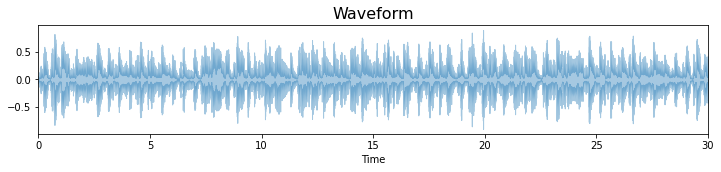

In [4]:
# Full path to the first blues song
filepath = '/content/gtzan-dataset-music-genre-classification/Data/genres_original/blues/blues.00000.wav'

# Import audio example
y, sr = librosa.load(filepath, sr = None)
# Visualize the waveform
plt.figure(figsize = (12, 2))
librosa.display.waveplot(y, sr,alpha=0.4)
plt.title("Waveform", fontsize = 16);
# Print information
print('Sample Rate [Hz]:', sr, '\n', 'Duration [s]:', len(y) / sr)

### 1. Tempo 

The 'speed' of a song, measured in beats per minute:

In [5]:
# Tempo 
tempo = librosa.beat.tempo(y)
print('Tempo [BPM]: ', tempo)

Tempo [BPM]:  [123.046875]


### 2. Harmonic and Percussive components

An audio time series can be decomposed into harmonic and percussive components. This can be viewed as separating features tied to pitch/frequency from features tied to time.

In [6]:
# Harmonic and Percussive Components
harmony, percuss = librosa.effects.hpss(y)

print('Harmonic Mean: ', np.mean(harmony), '\n', 'Harmonic Variance: ', np.var(harmony))
print('Percussive Mean: ', np.mean(percuss), '\n', 'Percussive Variance: ', np.var(percuss))

Harmonic Mean:  -4.5297264e-05 
 Harmonic Variance:  0.008172282
Percussive Mean:  7.783232e-06 
 Percussive Variance:  0.005698182


### 3. Chroma STFT. 

From Wikipedia:

*In music, the term chroma feature or chromagram closely relates to the twelve different pitch classes. Chroma-based features, which are also referred to as "pitch class profiles", are a powerful tool for analyzing music whose pitches can be meaningfully categorized (often into twelve categories) and whose tuning approximates to the equal-tempered scale. One main property of chroma features is that they capture harmonic and melodic characteristics of music, while being robust to changes in timbre and instrumentation.*

Chroma STFT Mean:  0.35008812 
 Chroma STFT Variance:  0.08875657


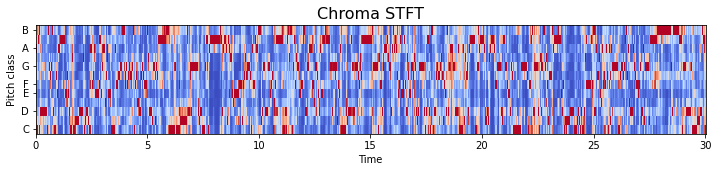

In [7]:
# Chroma STFT
chroma_stft = librosa.feature.chroma_stft(y, sr)
# Visualize
plt.figure(figsize = (12, 2))
librosa.display.specshow(chroma_stft, x_axis='time', y_axis='chroma',cmap='coolwarm')
plt.title("Chroma STFT", fontsize = 16);
# Mean and Variance
print('Chroma STFT Mean: ', np.mean(chroma_stft), '\n', 'Chroma STFT Variance: ', np.var(chroma_stft))

### 4. Spectral Centroid 

From Wikipedia:

*The spectral centroid is a measure used in digital signal processing to characterise a spectrum. It indicates where the center of mass of the spectrum is located. Perceptually, it has a robust connection with the impression of brightness of a sound.*

In [8]:
# Helper function to normalize audio data
def normalize(x, axis=0):
    return minmax_scale(x, axis=axis)

Spectral Centroid Mean:  1784.1658495387549 
 Spectral Centroid Variance:  129774.06452515078


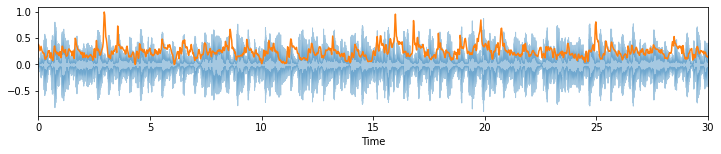

In [9]:
# Spectral Centroid
spectral_centroid = librosa.feature.spectral_centroid(y, sr)[0]

t = librosa.frames_to_time(range(len(spectral_centroid)))

plt.figure(figsize = (12, 2))
librosa.display.waveplot(y, sr=sr, alpha=0.4);
plt.plot(t, normalize(spectral_centroid));

print('Spectral Centroid Mean: ', np.mean(spectral_centroid), '\n', 'Spectral Centroid Variance: ', np.var(spectral_centroid))

### 5. Zero Crossing Rate 

The rate at which the waveform 'crosses' the zero value.

In [10]:
# Zero Crossing Rate
zero_crossing_rate = librosa.feature.zero_crossing_rate(y, sr)

print('Zero Crossing Rate Mean: ', np.mean(zero_crossing_rate), '\n', 'Zero Crossing Rate Variance: ', np.var(zero_crossing_rate))

# Total zero_crossings in selected sample
zero_crossings = librosa.zero_crossings(y, pad=False)
print('Total number of zero crosings: ',sum(zero_crossings))

Zero Crossing Rate Mean:  0.0823932460326229 
 Zero Crossing Rate Variance:  0.0002250008874842592
Total number of zero crosings:  55031


### 6. Mel Frequency Ceptstral Coefficients 

A very popular feature for audio processing when it comes to deep learning. Wikipedia can explain:

*Mel-frequency cepstral coefficients (MFCCs) are coefficients that collectively make up an MFC. They are derived from a type of cepstral representation of the audio clip (a nonlinear "spectrum-of-a-spectrum"). The difference between the cepstrum and the mel-frequency cepstrum is that in the MFC, the frequency bands are equally spaced on the mel scale, which approximates the human auditory system's response more closely than the linearly-spaced frequency bands used in the normal cepstrum. This frequency warping can allow for better representation of sound, for example, in audio compression.*

MFCC Means: [-113.57065, 121.57179, -19.168142, 42.36642, -6.364664, 18.623499, -13.704891, 15.34315, -12.27411, 10.976572, -8.326573, 8.803793, -3.6723, 5.747995, -5.162882, 0.75273985, -1.6902149, -0.40897894, -2.3035226, 1.2212901]
MFCC Variances: [2564.2075, 295.91382, 235.57443, 151.1069, 167.9348, 89.18084, 67.6605, 68.93258, 82.2042, 63.38631, 61.773087, 51.24412, 41.217415, 40.554478, 49.775425, 52.42091, 36.52407, 41.597103, 55.062923, 46.93603]


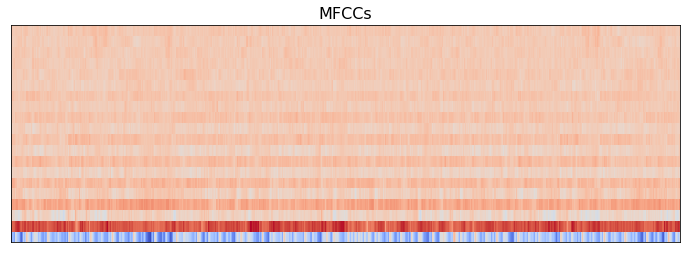

In [11]:
# MFCCs
mfcc = librosa.feature.mfcc(y, sr, n_mfcc=20)

mfcc_mean = []
mfcc_var = []
# Get list of mean and var for each component:
for n in range(20):
    mfcc_mean.append(np.mean(mfcc[n,:]))
    mfcc_var.append(np.var(mfcc[n,:]))
# Visualization
plt.figure(figsize = (12, 4))
librosa.display.specshow(mfcc)
plt.title("MFCCs", fontsize = 16);

print('MFCC Means:', mfcc_mean)
print('MFCC Variances:', mfcc_var)

## b. Creating a Feature dataframe

A dataframe can be assembled using the above features. The following functions are a breakdown of the pipeline used to generate this dataframe.

In [12]:
def initialize_dataframe():
    '''
    Initializes an empty dataframe with columns for the features to be extracted,
    plus the filenames and genre labels
    '''
    # Features to be inlcuded:
    columns = ['filename', 
               'tempo',
               'harmonic_mean',
               'harmonic_var',
               'percussive_mean',
               'percussive_var',
               'chroma_stft_mean',
               'chroma_stft_var',
               'spectral_centroid_mean',
               'spectral_centroid_var',
               'zero_crossing_rate_mean',
               'zero_crossing_rate_var'
               ]
    # MFCCs from 1 to 20
    columns.extend([f'mfcc_{i+1}_mean' for i in range(20)])
    columns.extend([f'mfcc_{i+1}_var' for i in range(20)])
    # Add labels (genre) column
    columns.extend(['genre'])
    # Generate the empty dataframe
    dataframe = pd.DataFrame(columns = columns)
    return dataframe

In [13]:
def extract_features(root, file, feat_cols):
    '''
    Extracts all features from an audio file and stores them in a dataframe to be
    used as a single row.
    '''
    # Load file (sr = 22050 by default)
    y, sr = librosa.load(root+'/'+file)
    # Get filename
    filename = file
    # Calculate tempo
    tempo = librosa.beat.tempo(y)[0]
    # Calculate harmonic and percussive components
    harmonic, percussive = librosa.effects.hpss(y)
    # Calculate chroma STFT
    chroma_stft = librosa.feature.chroma_stft(y)
    # Calculate spectral centroid
    spectral_centroid = librosa.feature.spectral_centroid(y)[0]
    # Calculate zero crossing rate
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y)
    # Make features list up til now
    features = [filename,
                tempo,
                np.mean(harmonic),
                np.var(harmonic),
                np.mean(percussive),
                np.var(percussive),
                np.mean(chroma_stft),
                np.var(chroma_stft),
                np.mean(spectral_centroid),
                np.var(spectral_centroid),
                np.mean(zero_crossing_rate),
                np.var(zero_crossing_rate)
                ]
    # Calculate the MFCCs
    mfcc = librosa.feature.mfcc(y, sr, n_mfcc=20)
    mfcc_mean = []
    mfcc_var = []
    # Get list of mean and var for each component:
    for n in range(20):
        mfcc_mean.append(np.mean(mfcc[n,:]))
        mfcc_var.append(np.var(mfcc[n,:]))

    # Add the MFCCs to the feature list
    features.extend(mfcc_mean)
    features.extend(mfcc_var)
  
    # Add the genre to the list, taken from the filename
    genre = filename.partition('.')[0]
    features.extend([genre])

    # Store everything in dataframe format
    temp_df = pd.DataFrame(columns = feat_cols, data = [features])

    return temp_df

In [14]:
def GTZAN_feature_dataframe(audio_path):
    '''
    Creates a dataframe for all the songs in the dataset, and populates it with
    by extracting audio features for each. 
    '''
    # Initialize dataframe
    df = initialize_dataframe()

    # Go through every audio file in the dataset and extract features
    for root, dirs, files in os.walk(audio_path, topdown=False):
        for name in files:
            # Create a temporary single row dataframe of features
            temp_df = extract_features(root, name, df.columns)
            # Add new entry as a row to the main dataframe
            df.append(temp_df, ignore_index = True)
    
    return df

Using these functions the dataframe can be generated in a single call, given the path to the audio dataset as an argument:

In [ ]:
# Path to dataset audio files
audio_path = '/content/gtzan-dataset-music-genre-classification/Data/genres_original'
# Generate dataframe
df = GTZAN_feature_dataframe(audio_path)
# Save as .csv

df_path = '../dataframes/feature_dataframe.csv'

df.to_csv(df_path, index=False) 

Now that the features are all stored in a dataframe, it can easily be read in:

In [16]:
df = pd.read_csv(df_path)
df.head()

,filename,tempo,harmonic_mean,harmonic_var,percussive_mean,percussive_var,chroma_stft_mean,chroma_stft_var,spectral_centroid_mean,spectral_centroid_var,zero_crossing_rate_mean,zero_crossing_rate_var,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,genre
0,blues.00000.wav,123.046875,-4.529724e-05,0.008172,0.000008,0.005698,0.350088,0.088757,1784.165850,129774.064525,0.083045,0.000767,-113.570648,2564.207520,121.571793,295.913818,-19.168142,235.574432,42.366421,151.106873,-6.364664,167.934799,18.623499,89.180840,-13.704891,67.660492,15.343150,68.932579,-12.274110,82.204201,10.976572,63.386311,-8.326573,61.773094,8.803792,51.244125,-3.672300,41.217415,5.747995,40.554478,-5.162882,49.775421,0.752740,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,67.999589,1.395807e-04,0.005099,-0.000178,0.003063,0.340914,0.094980,1530.176679,375850.073649,0.056040,0.001448,-207.501694,7764.555176,123.991264,560.259949,8.955127,572.810913,35.877647,264.506104,2.907320,279.932922,21.510466,156.477097,-8.560436,200.849182,23.370686,142.555954,-10.099661,166.108521,11.900497,104.358612,-5.555639,105.173630,5.376327,96.197212,-2.231760,64.914291,4.220140,73.152534,-6.012148,52.422142,0.927998,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,161.499023,2.105576e-06,0.016342,-0.000019,0.007458,0.363637,0.085275,1552.811865,156467.643368,0.076291,0.001007,-90.722595,3319.044922,140.446304,508.765045,-29.093889,411.781219,31.684334,144.090317,-13.984504,155.493759,25.764742,74.548401,-13.664875,106.981827,11.639934,106.574875,-11.783643,65.447945,9.718760,67.908859,-13.133803,57.781425,5.791199,64.480209,-8.907628,60.385151,-1.077000,57.711136,-9.229274,36.580986,2.451690,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,63.024009,4.583644e-07,0.019054,-0.000014,0.002712,0.404785,0.093999,1070.106615,184355.942417,0.033309,0.000423,-199.544205,5507.517090,150.090897,456.505402,5.662678,257.161163,26.859079,158.267303,1.771399,268.034393,14.234031,126.794128,-4.832006,155.912079,9.286494,81.273743,-0.759186,92.114090,8.137607,71.314079,-3.200653,110.236687,6.079319,48.251999,-2.480174,56.799400,-1.079305,62.289902,-2.870789,51.651592,0.780874,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,135.999178,-1.756129e-05,0.004814,-0.000010,0.003094,0.308526,0.087841,1835.004266,343399.939274,0.101461,0.001954,-160.337708,5195.291992,126.219635,853.784729,-35.587811,333.792938,22.148071,193.456100,-32.478600,336.276825,10.852294,134.831573,-23.352329,93.257095,0.498434,124.672127,-11.793437,130.073349,1.207256,99.675575,-13.088418,80.254066,-2.813867,86.430626,-6.933385,89.555443,-7.552725,70.943336,-9.164666,75.793404,-4.520576,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


The correlation matrix can be computed for features in the dataframe. The variance values are not considered in this example, and for convenience of conclusions the absolute value of the correlations is displayed.

Absolute correlation near zero indicates that features are independent from each other. 

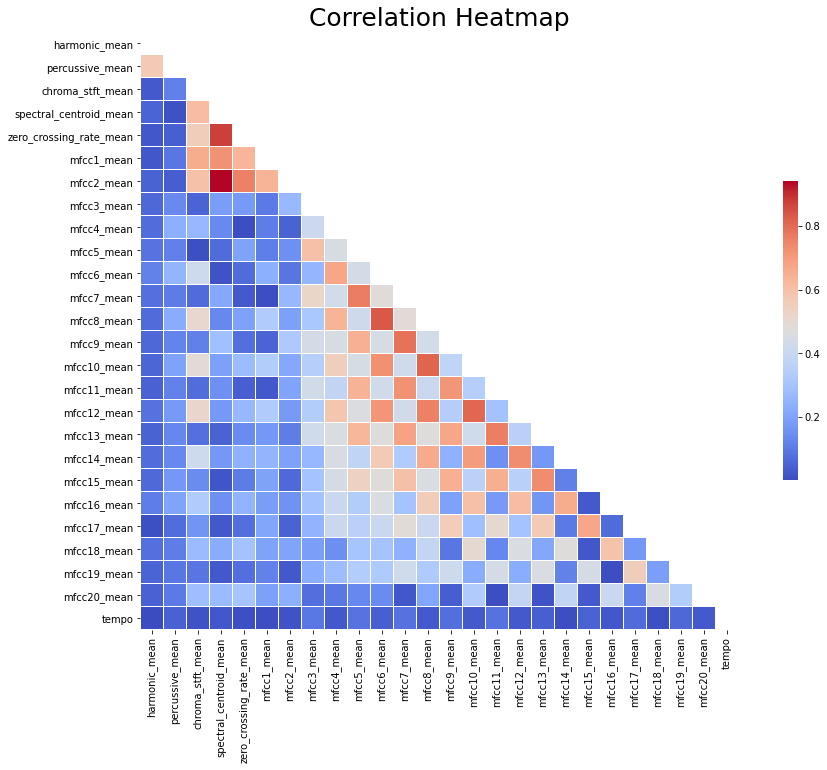

In [17]:
# Computing the Correlation Matrix
spike_cols = [col for col in df.columns if 'mean' in col]
spike_cols.append('tempo')
corr = np.abs(df[spike_cols].corr())

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 11));

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='coolwarm',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap', fontsize = 25)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);

This concludes an overview of the features included in this dataframe. Next step is to use these features and the labels assigned to each song, to build a genre classifier.

# Content-based Song Recommendation

A simple recommender system can now be defined to draw information from the audio content of a song through the extracted features, and provide the songs in the database that sound most like it.

For convenience in the next task, the dataframe will be reloaded with the filenames in place the index.

In [2]:
# Read dataframe, use filename as the index
df_path = '../dataframes/feature_dataframe.csv'

df = pd.read_csv(df_path, index_col='filename')

df.head()

,tempo,harmonic_mean,harmonic_var,percussive_mean,percussive_var,chroma_stft_mean,chroma_stft_var,spectral_centroid_mean,spectral_centroid_var,zero_crossing_rate_mean,zero_crossing_rate_var,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,genre
filename,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
blues.00000.wav,123.046875,-4.529724e-05,0.008172,0.000008,0.005698,0.350088,0.088757,1784.165850,129774.064525,0.083045,0.000767,-113.570648,2564.207520,121.571793,295.913818,-19.168142,235.574432,42.366421,151.106873,-6.364664,167.934799,18.623499,89.180840,-13.704891,67.660492,15.343150,68.932579,-12.274110,82.204201,10.976572,63.386311,-8.326573,61.773094,8.803792,51.244125,-3.672300,41.217415,5.747995,40.554478,-5.162882,49.775421,0.752740,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
blues.00001.wav,67.999589,1.395807e-04,0.005099,-0.000178,0.003063,0.340914,0.094980,1530.176679,375850.073649,0.056040,0.001448,-207.501694,7764.555176,123.991264,560.259949,8.955127,572.810913,35.877647,264.506104,2.907320,279.932922,21.510466,156.477097,-8.560436,200.849182,23.370686,142.555954,-10.099661,166.108521,11.900497,104.358612,-5.555639,105.173630,5.376327,96.197212,-2.231760,64.914291,4.220140,73.152534,-6.012148,52.422142,0.927998,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
blues.00002.wav,161.499023,2.105576e-06,0.016342,-0.000019,0.007458,0.363637,0.085275,1552.811865,156467.643368,0.076291,0.001007,-90.722595,3319.044922,140.446304,508.765045,-29.093889,411.781219,31.684334,144.090317,-13.984504,155.493759,25.764742,74.548401,-13.664875,106.981827,11.639934,106.574875,-11.783643,65.447945,9.718760,67.908859,-13.133803,57.781425,5.791199,64.480209,-8.907628,60.385151,-1.077000,57.711136,-9.229274,36.580986,2.451690,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
blues.00003.wav,63.024009,4.583644e-07,0.019054,-0.000014,0.002712,0.404785,0.093999,1070.106615,184355.942417,0.033309,0.000423,-199.544205,5507.517090,150.090897,456.505402,5.662678,257.161163,26.859079,158.267303,1.771399,268.034393,14.234031,126.794128,-4.832006,155.912079,9.286494,81.273743,-0.759186,92.114090,8.137607,71.314079,-3.200653,110.236687,6.079319,48.251999,-2.480174,56.799400,-1.079305,62.289902,-2.870789,51.651592,0.780874,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
blues.00004.wav,135.999178,-1.756129e-05,0.004814,-0.000010,0.003094,0.308526,0.087841,1835.004266,343399.939274,0.101461,0.001954,-160.337708,5195.291992,126.219635,853.784729,-35.587811,333.792938,22.148071,193.456100,-32.478600,336.276825,10.852294,134.831573,-23.352329,93.257095,0.498434,124.672127,-11.793437,130.073349,1.207256,99.675575,-13.088418,80.254066,-2.813867,86.430626,-6.933385,89.555443,-7.552725,70.943336,-9.164666,75.793404,-4.520576,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


### Names Dataframe

A helper dataframe containing the names of the songs and their artists can be assembled using the data provided by B.L. Sturm. The .txt file is read, the appropriate column names are assigned, and *nan* values are replaced by strings indicating that the entry is not available (N/A).

In [ ]:
df_names = pd.read_table('../dataframes/GTZANindex.txt', sep=' :::', header=None, engine='python')
df_names.columns = ['filename','Artist','Title']
df_names.fillna('N/A', inplace= True)
df_names.head()

,filename,Artist,Title
0,blues.00000.wav,John Lee Hooker,"One Bourbon, One Scotch And One Beer"
1,blues.00001.wav,John Lee Hooker,I'm In The Mood For Love
2,blues.00002.wav,John Lee Hooker,Think Twice Before You Go
3,blues.00003.wav,John Lee Hooker,I'm Bad Like Jesse James
4,blues.00004.wav,John Lee Hooker,N/A


Using the merge function, the genre can be conveniently included as a column.

In [ ]:
df_names = pd.merge(df_names, df.filter(['filename','genre']), how = 'inner', left_on='filename', right_on='filename')
df_names.head()

,filename,Artist,Title,genre
0,blues.00000.wav,John Lee Hooker,"One Bourbon, One Scotch And One Beer",blues
1,blues.00001.wav,John Lee Hooker,I'm In The Mood For Love,blues
2,blues.00002.wav,John Lee Hooker,Think Twice Before You Go,blues
3,blues.00003.wav,John Lee Hooker,I'm Bad Like Jesse James,blues
4,blues.00004.wav,John Lee Hooker,N/A,blues


The names dataframe can now be stored:

In [ ]:
# Save names dataframe as csv:
df_path = '../dataframes/names_dataframe.csv'
df_names.to_csv(df_path, index=False) 

... and easily accessed:

In [4]:
# Load names dataframe:
df_names = pd.read_csv('../dataframes/names_dataframe.csv')

One final modification to the features dataframe, in order to use it for getting recommendations, is to drop the "genre" column. Now, the dataframe consists purely of numerical features, extracted from the audio files.

In [5]:
# Extract labels
labels = df[['genre']]

# Drop labels from original dataframe
df = df.drop(columns=['genre', ])

In order to obtain recommendations based on the similarity between songs, a K-nearest neighbors classifier is called, using the Mahalanobis distance as a metric. This metric was settled upon after some experimentation, as it was found to produce the best results.

In [6]:
# Call Nearest Neighbors model:
model_knn = NearestNeighbors(metric = 'mahalanobis', metric_params={'V': np.cov(df, rowvar =False)}, algorithm="auto")
# Fit to feature dataframe:
model_knn.fit(df.values)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='mahalanobis',
                 metric_params={'V': array([[ 7.98863640e+02,  4.98597156e-05, -1.79836212e-02, ...,
        -5.06823226e+01, -3.65076463e+00, -4.55914457e+01],
       [ 4.98597156e-05,  2.83567277e-06,  1.43524991e-06, ...,
        -2.40342171e-03, -3.07938976e-04, -2.47883241e-03],
       [-1.79836212e-02,  1.43524991e-06,  1.35799848e-04, ...,
        -4.042...e-02],
       ...,
       [-5.06823226e+01, -2.40342171e-03, -4.04281350e-02, ...,
         1.38195321e+03,  1.25271108e+01,  1.46062198e+03],
       [-3.65076463e+00, -3.07938976e-04,  2.51269736e-03, ...,
         1.25271108e+01,  1.47226212e+01,  1.25149194e+01],
       [-4.55914457e+01, -2.47883241e-03, -6.01000285e-02, ...,
         1.46062198e+03,  1.25149194e+01,  2.04561826e+03]])},
                 n_jobs=None, n_neighbors=5, p=2, radius=1.0)

It is only a matter of defining a simple to find the nearest neighbors for a given song in the above dataframe. The 5 most similar sounding songs are returned as recommendations.

In [7]:
def recommend_songs(song = "", n_recs = 5):
    '''
    Gives song recommendations from the GTZAN dataset based on extracted features.
    args:
      song (string) : filename as it appears in GTZAN
      n_recs (int) : number of songs to recommend (essentially nearest neighbors)

    returns:
      recommended_filenames (str) : list of filenames for the recommended songs
    '''    
    # Identify selected song:
    selected_song = df_names.loc[df_names['filename'] == song, ['Artist', 'Title', 'genre']]
    
    # Print song title and artist:
    print('If you like\n', 
          str(selected_song.Artist.values[0])
          +' -'+str(selected_song.Title.values[0]))
    
    print('\n You might enjoy the following songs:\n')
    
    # Find similar songs by implementing KNN - 
    # an additional neighbor is used, as the first result is the selected song itself:
    distances, indices = model_knn.kneighbors(df.loc[song,:].values.reshape(1,-1),
                                              n_neighbors = n_recs + 1) 
    
    recommended_filenames = []
    
    # Generate recommendations list, and print song titles and artists:
    for i in range(0, len(distances.flatten())):
        # Get filename:
        recommended_filename = df.index[indices.flatten()[i]]
        # Append list:
        recommended_filenames.append(recommended_filename)
        
        if i > 0:
        
          # Locate song title, artist. genre:
          temp_row = df_names.loc[df_names['filename'] == recommended_filename,
                                  ['Artist', 'Title', 'genre']]
          # Display song info:
          print(str(temp_row.Artist.values[0])+
                ' -'+str(temp_row.Title.values[0])+
                ' ('+str(temp_row.genre.values[0])+')')

    return recommended_filenames

Putting this to the test, file 'rock.00069.wav' is selected. This proves to be a song by Jethro Tull (Witches Promise). The similar songs returned are:

In [8]:
song = 'rock.00069.wav'
similar_songs = recommend_songs(song)

If you like
  Jethro Tull - Witches Promise

 You might enjoy the following songs:

 Brad Paisley - The Nervous Breakdown (country)
 Jethro Tull - Living In The Past (rock)
 Jethro Tull - Sweet Dream (rock)
 Bob Marley - So Much Trouble In The World (reggae)
 Queen - Tutti Frutti (rock)


The list includes two more entries by Jethro Tull, another entry in the rock genre (Queen's live rendition of Tutti Frutti), a country and a reggae song. 

It is evident that the system is completely uninfluenced by external labels of genre and Artist name, however, in order to better evaluate its success, it is useful to actually listen to the samples from which the features were extracted.

Using the IPython library and the original GTZAN audio dataset, a function can be written that allows the embedded playback of each song. 

This function takes in as arguments the filename as stored in GTZAN, and the path to the audio dataset. 

In [9]:
# Path to dataset audio files
audio_path = '/content/gtzan-dataset-music-genre-classification/Data/genres_original'

def GTZAN_listen(fname, directory = audio_path):
    # Get genre from filename to fill path:
    genre = fname.partition('.')[0]
    # Embed audio file:
    listen = ipd.Audio(audio_path+'/'+genre+'/'+fname)

    # Temporary row to store names:
    temp_row = df_names.loc[df_names['filename'] == fname, ['Artist', 'Title', 'genre']]
    # Display Artist and Title
    print(str(temp_row.Artist.values[0])+' -'+str(temp_row.Title.values[0]))
    
    return listen

Each song in the list of recommendations (or the 30 seconds of it that made it into the GTZAN dataset). Entry 0 is the selected song.

Listening to each of the results, one can recognise a similar instrumentation, vocal timbre, and tempo. And it is easy to argue that they would not sound out of place in a playlist.

It can therefore be concluded that the simple model presented here constitutes an adequate recommendation engine. Even if most of the selected audio features had to be averaged over the relatively long duration of 30 seconds, it appears that they still manage to convey high-level characteristics of the sound through their mean value and variance.

In [10]:
# Call function and song filename to listen:
GTZAN_listen(similar_songs[0])

 Jethro Tull - Witches Promise
